
# Python Preprocessing

In this note, I will show basic method to do the preprocessing. The idea is simple:

1. Change file names (see the section 1 below)
2. Subtract bias and/or dark from object and flat images
3. Do flat fielding to the object image.

Details of the last two steps:

1. Dark of exposure time < 1 s is regarded as bias
2. Flat is bias subtracted, and then the Poisson error is calculated.
3. Do dark subtraction and flat fielding for only the images which has proper ``OBJECT`` keyword in header.

I will use 2018-04-12 data of TRIPOL obtained by the "comet" group and by the TAs. The data is accessible from our NAS server:
* https://147.46.40.80:5003
* ID = tripol PW = (same as astro wifi)


First, the following long code contains definitions of some useful functions. I will use them throughout this lecture note. You may use these functions freely for your group project works.

In [10]:
import warnings
from pathlib import Path

import numpy as np
from scipy.stats import itemfreq

from astropy.io import fits
from astropy import units as u
from astropy.table import Table, Column
from astropy.nddata import CCDData
from astropy.modeling.functional_models import Gaussian1D
from astropy.modeling.fitting import LevMarLSQFitter

from ccdproc import combine
from ccdproc import sigma_func as ccdproc_mad2sigma_func


def mkdir(fpath, mode=0o777, exist_ok=True):
    ''' Convenience function for Path.mkdir()
    '''
    fpath = Path(fpath)
    Path.mkdir(fpath, mode=mode, exist_ok=exist_ok)
    
    
def fitsrenamer(fpath, rename_by=["OBJECT"], delimiter='_', add_header=None,
    mkdir_by=None):
    ''' Renames a FITS file by ``rename_by`` with delimiter.
    Parameters
    ----------
    fpath: path-like
        The path to the target FITS file.
    rename_by: list of str, optional
        The keywords of the FITS header to rename by.
    delimiter: str, optional
        The delimiter for the renaming.
    add_header: header or dict
        The header keyword, value (and comment) to add after the renaming.
    mkdir_by: list of str, optional
        The keys which will be used to make subdirectories to classify files.
        If given, subdirectories will be made with the header value of the keys.
    '''

    # Load fits file
    hdul = fits.open(fpath)
    hdr = hdul[0].header

    # add keyword
    if add_header is not None:
        hdr += add_header

    # Set the new name
    newname = ""
    for k in rename_by:
        newname += str(hdr[k])
        newname += delimiter
    newname = newname[:-1] + '.fits'

    # Set the new path
    newpath = Path(fpath.parent)
    if mkdir_by is not None:
        for k in mkdir_by:
            newpath = newpath / hdr[k]
    newpath = newpath / newname
    mkdir(newpath.parent)
    
    print(f"Rename {fpath.name} to {newpath}")
    fpath.rename(newpath)

    return newpath


def load_if_exists(path, loader, if_not=None, **kwargs):
    ''' Load a file if it exists.
    Parameters
    ----------
    path: pathlib.Path of Path-like str
        The path to be searched.
    loader: a function
        The loader to load ``path``. Can be ``CCDData.read``, ``np.loadtxt``, etc.
    if_not: str
        Give a python code as a str to be run if the loading failed.
    Returns
    -------
    loaded:
        The loaded file. If the file does not exist, ``None`` is returned.
    '''
    path = Path(path)
    if path.exists():
        print(f'Loading the existing {str(path)}...', end='')
        loaded = loader(path, **kwargs)
        print(" Done")
    elif if_not is not None:
        loaded = eval(if_not)
    else:
        loaded = None
    return loaded

def stack_FITS(filelist, extension, unit='adu', trim_fits_section=None,
               type_key=None, type_val=None):
    ''' Stacks the FITS files specified in filelist
    Parameters
    ----------
    filelist: str, path-like, or list of such
        The list of FITS files to be stacked

    extension: int or str
        The extension of FITS to be stacked. For single extension, set it as 0.

    unit: Unit or str, optional

    trim_fits_section: str, optional
        Region of ``ccd`` to be trimmed; see ``ccdproc.subtract_overscan`` for
        details. Default is None.

    Return
    ------
    all_ccd: list
        list of ``CCDData``
    '''

    iskey = False
    filelist = list(filelist)

    if ((type_key == None) ^ (type_val == None)):
        raise KeyError(
            "type_key and type_val must be both specified or both None.")

    if type_key != None:
        iskey = True
        if isinstance(type_key, str):
            type_key = [type_key]
        if isinstance(type_val, str):
            type_val = [type_val]

        if len(type_key) != len(type_val):
            raise ValueError(
                "type_key and type_val must be of the same length.")

    all_ccd = []

    for i, fname in enumerate(filelist):
        ccd_i = CCDData.read(fname, hdu=extension,
                             unit=unit)  # unit is just dummy

        if iskey:
            mismatch = False
            for k, v in zip(type_key, type_val):
                if (ccd_i.header[k] != v):
                    mismatch = True
                    break
            if mismatch:
                continue

        if trim_fits_section is not None:
            ccd_i = ccdproc.trim_image(ccd_i, fits_section=trim_fits_section)

        all_ccd.append(ccd_i)
#        im_i = hdu_i[extension].data
#        if (i == 0):
#            all_data = im_i
#        elif (i > 0):
#            all_data = np.dstack( (all_data, im_i) )

    if len(all_ccd) == 0:
        if iskey:
            warnings.warn('No FITS file had "{:s} = {:s}"'.format(str(type_key),
                                                                  str(type_val)))
        else:
            warnings.warn('No FITS file found')
    else:
        if iskey:
            print('{:d} FITS files with "{:s} = {:s}"'
                  ' are loaded.'.format(len(all_ccd),
                                        str(type_key),
                                        str(type_val)))
        else:
            print('{:d} FITS files are loaded.'.format(len(all_ccd)))

    return all_ccd


def CCDData_astype(ccd, dtype='float32'):
    ccd.data = ccd.data.astype(dtype)
    try:
        ccd.uncertainty.array = ccd.uncertainty.array.astype(dtype)
    except AttributeError:
        pass
    return ccd


def combine_ccd(fitslist, trim_fits_section=None, output=None, unit='adu',
                subtract_frame=None, combine_method='median', reject_method=None,
                normalize=False, exposure_key='EXPTIME',
                combine_uncertainty_function=ccdproc_mad2sigma_func,
                extension=0, min_value=0, type_key=None, type_val=None,
                dtype=np.float32, output_verify='fix', overwrite=False,
                **kwargs):
    ''' Combining images
    Slight variant from ccdproc.
    # TODO: accept the input like ``sigma_clip_func='median'``, etc.
    # TODO: normalize maybe useless..?
    Parameters
    ----------
    fitslist: list of str, path-like
        list of FITS files.

    combine: str
        The ``method`` for ``ccdproc.combine``, i.e., {'average', 'median', 'sum'}

    reject: str
        Made for simple use of ``ccdproc.combine``,
        {None, 'minmax', 'sigclip' == 'sigma_clip', 'extrema'}. Automatically turns
        on the option, e.g., ``clip_extrema = True`` or ``sigma_clip = True``.
        Leave it blank for no rejection.

    type_key, type_val: str, list of str
        The header keyword for the ccd type, and the value you want to match.
        For an open HDU named ``hdu``, e.g., only the files which satisfies
        ``hdu[extension].header[type_key] == type_val`` among all the ``fitslist``
        will be used.

    **kwarg:
        kwargs for the ``ccdproc.combine``. See its documentation.
        This includes (RHS are the default values)
        ```
        weights=None,
        scale=None,
        mem_limit=16000000000.0,
        clip_extrema=False,
        nlow=1,
        nhigh=1,
        minmax_clip=False,
        minmax_clip_min=None,
        minmax_clip_max=None,
        sigma_clip=False,
        sigma_clip_low_thresh=3,
        sigma_clip_high_thresh=3,
        sigma_clip_func=<numpy.ma.core._frommethod instance>,
        sigma_clip_dev_func=<numpy.ma.core._frommethod instance>,
        dtype=None,
        combine_uncertainty_function=None, **ccdkwargs
        ```

    Returns
    -------
    master: astropy.nddata.CCDData
        Resulting combined ccd.

    '''

    def _set_reject_method(reject_method):
        ''' Convenience function for ccdproc.combine reject switches
        '''
        clip_extrema, minmax_clip, sigma_clip = False, False, False

        if reject_method == 'extrema':
            clip_extrema = True
        elif reject_method == 'minmax':
            minmax_clip = True
        elif ((reject_method == 'sigma_clip') or (reject_method == 'sigclip')):
            sigma_clip = True
        else:
            if reject_method is not None:
                raise KeyError("reject must be one of "
                            "{None, 'minmax', 'sigclip' == 'sigma_clip', 'extrema'}")

        return clip_extrema, minmax_clip, sigma_clip


    def _print_info(combine_method, Nccd, reject_method, **kwargs):
        if reject_method is None:
            reject_method = 'no'

        info_str = ('"{:s}" combine {:d} images by "{:s}" rejection')

        print(info_str.format(combine_method, Nccd, reject_method))
        print(dict(**kwargs))
        return


    def _ccdproc_combine(ccdlist, combine_method, min_value=0,
                        combine_uncertainty_function=ccdproc_mad2sigma_func,
                        **kwargs):
        ''' Combine after minimum value correction and then rejection/trimming.
        ccdlist:
            list of CCDData

        combine_method: str
            The ``method`` for ``ccdproc.combine``, i.e., {'average', 'median',
            'sum'}

        **kwargs:
            kwargs for the ``ccdproc.combine``. See its documentation.
        '''
        if not isinstance(ccdlist, list):
            ccdlist = [ccdlist]

        # copy for safety
        use_ccds = ccdlist.copy()

        # minimum value correction and trim
        for ccd in use_ccds:
            ccd.data[ccd.data < min_value] = min_value

        #combine
        ccd_combined = combine(img_list=use_ccds,
                            method=combine_method,
                            combine_uncertainty_function=combine_uncertainty_function,
                            **kwargs)

        return ccd_combined


    def _normalize_exptime(ccdlist, exposure_key):
        _ccdlist = ccdlist.copy()
        exptimes = []

        for i in range(len(_ccdlist)):
            exptime = _ccdlist[i].header[exposure_key]
            exptimes.append(exptime)
            _ccdlist[i] = _ccdlist[i].divide(exptime)

        if len(np.unique(exptimes)) != 1:
            print('There are more than one exposure times:')
            print('\texptimes =', end=' ')
            print(np.unique(exptimes), end=' ')
            print('seconds')
        print('Normalized images by exposure time ("{:s}").'.format(exposure_key))

        return _ccdlist


    fitslist = list(fitslist)

    if (output is not None) and (Path(output).exists()):
        if overwrite:
            print(f"{output} already exists:\n\t", end='')
            print("But will be overridden.")
        else:
            print(f"{output} already exists:\n\t", end='')
            return load_if_exists(output, loader=CCDData.read, if_not=None)


    ccdlist = stack_FITS(filelist = fitslist,
                         extension = extension,
                         unit = unit,
                         trim_fits_section = trim_fits_section,
                         type_key = type_key,
                         type_val = type_val)
    header = ccdlist[0].header

    _print_info(combine_method = combine_method,
                Nccd = len(ccdlist),
                reject_method = reject_method,
                min_value = min_value,
                dtype = dtype,
                **kwargs)

    # Normalize by exposure
    if normalize:
        ccdlist = _normalize_exptime(ccdlist, exposure_key)

    # Set rejection switches
    clip_extrema, minmax_clip, sigma_clip = _set_reject_method(reject_method)

    master = _ccdproc_combine(ccdlist=ccdlist,
                              combine_method=combine_method,
                              min_value=min_value,
                              clip_extrema=clip_extrema,
                              minmax_clip=minmax_clip,
                              sigma_clip=sigma_clip,
                              combine_uncertainty_function=combine_uncertainty_function,
                              **kwargs)

    str_history = '{:d} images {:s} combined for {:s} = {:s}'
    header.add_history(str_history.format(len(ccdlist),
                                          str(combine_method),
                                          str(type_key),
                                          str(type_val)))
    header["NCOMBINE"] = len(ccdlist)

    if subtract_frame is not None:
        subtract = CCDData(subtract_frame.copy())
        master = master.subtract(subtract)
        header.add_history("Subtracted a user-provided frame")

    master.header = header
    master = CCDData_astype(master, dtype=dtype)

    if output is not None:
        master.write(output, output_verify=output_verify, overwrite=overwrite)

    return master

def make_errmap(ccd, gain_epadu, ronoise_electron=0,
                subtracted_dark=None):
    ''' Calculate the usual error map.
    Parameters
    ----------
    ccd: array-like
        The ccd data which will be used to generate error map. It must be bias
        subtracted. If dark is subtracted, give ``subtracted_dark``. If the
        amount of this subtracted dark is negligible, you may just set
        ``subtracted_dark = None`` (default).
    gain: float, array-like, or Quantity
        The effective gain factor in ``electron/ADU`` unit.
    ronoise: float, array-like, or Quantity, optional.
        The readout noise. Put ``ronoise=0`` will calculate only the Poissonian
        error. This is useful when generating noise map for dark frames.
    subtracted_dark: array-like
        The subtracted dark map.
    '''
    data = ccd.copy()

    if isinstance(data, CCDData):
        data = data.data

    data[data < 0] = 0 # make all negative pixel to 0
    
    if isinstance(gain_epadu, u.Quantity):
        gain_epadu = gain.to(u.electron / u.adu).value

    if isinstance(ronoise_electron, u.Quantity):
        ronoise_electron = ronoise_electron.to(u.electron)

    # Get Poisson noise
    if subtracted_dark is not None:
        dark = subtracted_dark.copy()
        if isinstance(dark, CCDData):
            dark = dark.data
        # If subtracted dark is negative, this may cause negative pixel in ``data``:
        data += dark

    var_Poisson = data / gain_epadu  # (data * gain) / gain**2 to make it ADU
    var_ROnoise = (ronoise_electron / gain_epadu)**2

    errmap = np.sqrt(var_Poisson + var_ROnoise)

    return errmap


def make_summary(filelist, extension=0, fname_option = 'relative',
                 output=None, format='ascii.csv',
                 keywords = [], dtypes = [], chmod = 777,
                 example_header = None, sort_by='file', verbose=True):
    """ Extracts summary from the headers of FITS files.
    Parameters
    ----------
    filelist: list of str (path-like)
        The list of file paths relative to the current working directory.

    extension: int or str
        The extension to be summarized.

    fname_option: str {'absolute', 'relative', 'name'}
        Whether to save full absolute/relative path or only the filename.

    ouput: str or path-like
        The directory and file name of the output summary file. Leave blank
        for not saving anything.

    format: str
        The astropy.table.Table output format.

    keywords: list
        The list of the keywords to extract (keywords should be in ``str``).

    dtypes: list
        The list of dtypes of keywords if you want to specify. If ``[]``,
        ``['U80'] * len(keywords)`` will be used. Otherwise, it should have
        the same length with ``keywords``.

    chmod: int
        the chmod code (e.g., 777 for ``rwxrwxrwx``).

    example_header: str or path-like
        The path including the filename of the output summary text file.

    sort_by: str
        The column name to sort the results. It can be any element of
        ``keywords`` or ``'file'``, which sorts the table by the file name.
    """

    def _get_fname(path):
        if fname_option == 'relative':
            return str(path)
        elif fname_option == 'absolute':
            return str(path.absolute())
        else:
            return path.name

    options = ['absolute', 'relative', 'name']
    if fname_option not in options:
        raise KeyError(f"fname_option must be one of {options}.")

    skip_keys = ['COMMENT', 'HISTORY']

    if verbose:
        if (keywords != []) and (keywords != '*'):
            print("Extracting keys: ", keywords)
        str_example_hdr = "Extract example header from {:s}\n\tand save as {:s}"
        str_keywords = "All {:d} keywords will be loaded."
        str_keyerror_fill = "Key {:s} not found for {:s}, filling with '--'."
        str_valerror = "Please use 'U80' as the dtype for the key {:s}."
        str_filesave = 'Saving the summary file to "{:s}"'



    # Save example header
    if example_header is not None:
        example_fits = filelist[0]
        if verbose:
            print(str_example_hdr.format(str(example_fits), example_header))
        ex_hdu = fits.open(example_fits)
        ex_hdr = ex_hdu[extension].header
        ex_hdr.totextfile(example_header, overwrite=True)

    # load ALL keywords for special cases
    if (keywords == []) or (keywords == '*'):
        example_fits = filelist[0]
        ex_hdu = fits.open(example_fits)
        ex_hdu.verify('fix')
        ex_hdr = ex_hdu[extension].header
        N_hdr = len(ex_hdr.cards)
        keywords = []
        for i in range(N_hdr):
            key_i = ex_hdr.cards[i][0]
            if (key_i in skip_keys):
                continue
            elif (key_i in keywords):
                str_duplicate = "Key {:s} is duplicated! Only first one will be saved."
                print(str_duplicate.format(key_i))
                continue
            keywords.append(key_i)
        if verbose:
            print(str_keywords.format(len(keywords)))

    # Initialize
    if len(dtypes) == 0:
        dtypes = ['U80'] * len(keywords)
        # FITS header MUST be within 80 characters! (FITS standard)

    summarytab = Table(names=keywords, dtype=dtypes)
    fnames = []

    # Run through all the fits files
    for fitsfile in filelist:
        fitsfile.chmod(chmod)
        fnames.append(_get_fname(fitsfile))
        hdu = fits.open(fitsfile)
        hdu.verify('fix')
        hdr = hdu[extension].header
        row = []
        for key in keywords:
            try:
                row.append(hdr[key])
            except KeyError:
                if verbose:
                    print(str_keyerror_fill.format(key, str(fitsfile)))
                try:
                    row.append('--')
                except ValueError:
                    raise ValueError(str_valerror.format('U80'))
        summarytab.add_row(row)
        hdu.close()

    # Attache the file name, and then sort by file name.
    fnames = Column(data=fnames, name='file')
    summarytab.add_column(fnames, index=0)
    summarytab.sort(sort_by)


    # sort by a key if ``sort_by`` is given
    if ((sort_by != '') and (sort_by != None)):
        summarytab.sort('file')

    if output is not None:
        if verbose:
            print(str_filesave.format(str(output)))
        summarytab.write(output, format=format, overwrite=True)

    return summarytab

    

def Gfit2hist(data):
    ''' Gaussian fit to the frequency distribution of the nddata.
    '''
    freq = itemfreq(data.flatten())
    fitter = LevMarLSQFitter()
    mode = freq[freq[:, 1] == freq[:, 1].max(), 0][0]
    init = Gaussian1D(mean=mode)
    fitG = fitter(init, freq[:, 0], freq[:, 1])
    return fitG

def bias2ronoise(data):
    ''' Infer readout noise from bias image.
    '''
    fitG = Gfit2hist(data)
    return fitG.stddev.value

The above functions are a part of my personal package for astronomical data reduction and simulation. If you want, you may copy-and-paste the above code and save it as, e.g., ``AO1util.py``, and at the same directory, you can import that file by using
```python
import AO1util
AO1util.make_summary(~~~~~~)
...
```

## 1. File Renamer

TRIPOL by default takes 3-band images (g' r' i') simultaneously and saves them with file name ``f_yymmdd_xxxx.fits`` where ``f`` is the filter name (``g``, ``r``, ``i``), ``yymmdd`` is the sidereal date (e.g., ``180412``), and ``xxxx`` is the counter with up to 4 digits with leading zero filling (e.g., ``0012``).

There are some inconveniences on this:

1. Object name and exposure times are not written.
2. The three FITS files (g, r, i bands) share the same counter.
3. Flat images must be taken differently for each band but all 3 images are saved. You must specify which flat you took in ``OBJECT`` key in the header.
4. Since bias and dark images are different in each CCD, we need to make 3 master dark or bias images, too.

So I want to first rename all the files:

1. Make name as ``counter_target_exposuretime.fits``.
2. Save that file at a directory ``g``, ``r``, or ``i`` depending on their header keyword ``FILTER``.

Then you may do preprocessing at each directory.

In [11]:
rename_by = ["COUNTER", "OBJECT", "EXPOS"]
mkdir_by = ["FILTER"]
TOPPATH = Path('180412', 'rawdata')
# Set the path as the path where your FITS files are
filelist = list(TOPPATH.glob('*.fits'))

for fpath in filelist:
    # If it is TL image (e.g., ``g.fits``), delete it
    try:
        counter = fpath.name.split('_')[1][:4]
    except IndexError:
        print(f"deleting TL image: {fpath.name}")
        fpath.unlink()
        continue
    
    # Set the ``COUNTER`` keyword    
    counter = fpath.name.split('_')[1][:4]
    newname = fitsrenamer(fpath, rename_by=rename_by, delimiter='_', 
                          add_header={"COUNTER": counter},
                          mkdir_by=mkdir_by)    

Rename g180412_0073.fits to 180412/rawdata/g/0073_dark_120.0.fits
Rename r180412_0027.fits to 180412/rawdata/r/0027_TEST_10.0.fits
Rename i180412_0026.fits to 180412/rawdata/i/0026_TEST_10.0.fits
Rename r180412_0031.fits to 180412/rawdata/r/0031_TEST_60.0.fits
Rename g180412_0068.fits to 180412/rawdata/g/0068_TEST_60.0.fits
Rename i180412_0063.fits to 180412/rawdata/i/0063_TEST_120.0.fits
Rename r180412_0118.fits to 180412/rawdata/r/0118_dark_0.4.fits
Rename r180412_0095.fits to 180412/rawdata/r/0095_TEST_10.0.fits
Rename i180412_0098.fits to 180412/rawdata/i/0098_TEST_600.0.fits
Rename r180412_0138.fits to 180412/rawdata/r/0138_dark_5.0.fits
Rename i180412_0055.fits to 180412/rawdata/i/0055_TEST_10.0.fits
Rename i180412_0071.fits to 180412/rawdata/i/0071_TEST_30.0.fits
Rename g180412_0022.fits to 180412/rawdata/g/0022_TEST_1.0.fits
Rename r180412_0080.fits to 180412/rawdata/r/0080_dark_120.0.fits
Rename i180412_0141.fits to 180412/rawdata/i/0141_dark_5.0.fits
Rename i180412_0138.fits 

Rename i180412_0050.fits to 180412/rawdata/i/0050_TEST_10.0.fits
Rename r180412_0090.fits to 180412/rawdata/r/0090_TEST_10.0.fits
Rename r180412_0069.fits to 180412/rawdata/r/0069_TEST_120.0.fits
Rename i180412_0131.fits to 180412/rawdata/i/0131_dark_2.0.fits
Rename g180412_0057.fits to 180412/rawdata/g/0057_TEST_10.0.fits
Rename r180412_0022.fits to 180412/rawdata/r/0022_TEST_1.0.fits
Rename i180412_0103.fits to 180412/rawdata/i/0103_flat_g_2.0.fits
Rename r180412_0127.fits to 180412/rawdata/r/0127_dark_2.0.fits
Rename i180412_0109.fits to 180412/rawdata/i/0109_flat_r_0.4.fits
Rename g180412_0103.fits to 180412/rawdata/g/0103_flat_g_2.0.fits
Rename i180412_0069.fits to 180412/rawdata/i/0069_TEST_120.0.fits
Rename r180412_0103.fits to 180412/rawdata/r/0103_flat_g_2.0.fits
Rename r180412_0079.fits to 180412/rawdata/r/0079_dark_120.0.fits
Rename i180412_0053.fits to 180412/rawdata/i/0053_TEST_100.0.fits
Rename i180412_0029.fits to 180412/rawdata/i/0029_TEST_10.0.fits
Rename i180412_0007.

Rename r180412_0001.fits to 180412/rawdata/r/0001_TEST_1.0.fits
Rename g180412_0002.fits to 180412/rawdata/g/0002_TEST_1.0.fits
Rename g180412_0075.fits to 180412/rawdata/g/0075_dark_120.0.fits
Rename r180412_0070.fits to 180412/rawdata/r/0070_TEST_30.0.fits
Rename g180412_0071.fits to 180412/rawdata/g/0071_TEST_30.0.fits
Rename g180412_0102.fits to 180412/rawdata/g/0102_flat_g_2.0.fits
Rename i180412_0031.fits to 180412/rawdata/i/0031_TEST_60.0.fits
Rename i180412_0118.fits to 180412/rawdata/i/0118_dark_0.4.fits
Rename r180412_0084.fits to 180412/rawdata/r/0084_HIP66872_120.0.fits
Rename g180412_0038.fits to 180412/rawdata/g/0038_TEST_60.0.fits
Rename i180412_0065.fits to 180412/rawdata/i/0065_TEST_10.0.fits
Rename g180412_0042.fits to 180412/rawdata/g/0042_HIP61602_120.0.fits
Rename g180412_0087.fits to 180412/rawdata/g/0087_TEST_300.0.fits
Rename i180412_0136.fits to 180412/rawdata/i/0136_dark_5.0.fits
Rename i180412_0113.fits to 180412/rawdata/i/0113_flat_i_5.0.fits
Rename i180412_

The resulting files will have this kind of tree:
```
├── rawdata
│   ├── g
│   │   ├── 0001_TEST_1.0.fits
│   │   ├── 0002_TEST_1.0.fits
│   │   ├── 0003_TEST_1.0.fits
...
│   ├── i
│   │   ├── 0001_TEST_1.0.fits
│   │   ├── 0002_TEST_1.0.fits
│   │   ├── 0003_TEST_1.0.fits
...
│   └── r
│       ├── 0001_TEST_1.0.fits
│       ├── 0002_TEST_1.0.fits
│       ├── 0003_TEST_1.0.fits
...
3 directories, 429 files
```

## 2. Generate Bias, Dark, and Flat

In this code, I will make bias for each filter, and dark for each filter and each exposure time. Then make bias and dark subtracted flat image.

The files ``Dark_<filter>_<exptime>.fits`` are the raw darks (bias not subtracted). 

For each CCD, we have dummy flats, so we have to carefully choose which frame to use for each CCD's flat. In the observation, we set the ``OBJECT`` key value as ``flat_x`` for filter ``x`` (``g``, ``r``, ``i``). For flat, bias and puredark (bias subtracted dark) are both subtracted, and there will be **one more extension called ``"UNCERT"``.**

In [14]:
from ccdproc import subtract_bias, subtract_dark, flat_correct, create_deviation

# Initial setting
MEDCOMB_KEYS = dict(dtype='float32',
                    combine_method="median",
                    reject_method=None,
                    combine_uncertainty_function=None)
keymap = dict(EXPTIME = 'EXPOS', GAIN = 'EGAIN', OBJECT = 'OBJECT', FILTER='FILTER')
filters = ['g', 'r', 'i']
gains = {}

# Do dark combine, etc, for each filter:
for filt in filters:
    # Find all FITS files and make a summary table
    filelist = list((TOPPATH / filt).glob('*.fits'))
    filetable = make_summary(filelist, output=None)
    # If you want to save and manually see the summary. See the homework below.
    
    # Select only "dark" frames and "flat" of given filter
    darktable = filetable[filetable[keymap["OBJECT"]]=="dark"]
    flattable = filetable[filetable[keymap["OBJECT"]]==f"flat_{filt}"]

    # Set save path
    biaspath = REDUCED / f"Bias_{filt}.fits"
    flatpath = REDUCED / f"Flat_{filt}.fits"


    # Initialize for different exptime for dark frames
    darks = {}
    
    # For each dark frames grouped by exposure time, combine and save dark frame:
    for group in darktable.group_by(keymap["EXPTIME"]).groups:
        # Find exposure time
        exptime_dark = float(group[keymap["EXPTIME"]][0])
        
        # Set save path
        darkpath = REDUCED / f"Dark_{filt}_{exptime_dark}s.fits"
        
        # Dark combine
        mdark = combine_ccd(group["file"], 
                            output=darkpath,
                            overwrite=True,
                            **MEDCOMB_KEYS,
                            type_key=[keymap["FILTER"], keymap["EXPTIME"]],
                            type_val=[filt, exptime_dark])
        
        # archive for future use (if memory is problematic, you shouldn't do this)
        darks[exptime_dark] = mdark

    # Find suitable bias image
    exptime_dark_min = min(darks.keys())
    if exptime_dark_min < 1:
        # Find which to use bias
        bias = darks[exptime_dark_min]
        bias.write(biaspath, overwrite=True)
        print(f"Using dark with exposure {min(darks.keys())}s as bias ({biaspath})")
    
    else:
        warnings.warn(f"Minimum dark exposure is too long ({exptime_dark_min} sec)!"
                      " I think you have no file for bias...")
    
    gain = float(darktable[keymap["GAIN"]][0]) * u.electron / u.adu
    gains[filt] = gain
    
    # Flat combine 
    exptime_flat = float(flattable[keymap['EXPTIME']][0])
    mflat = combine_ccd(flattable["file"], 
                        **MEDCOMB_KEYS,
                        type_key=[keymap["FILTER"], keymap["EXPTIME"]],
                        type_val=[filt, exptime_flat])
    
    # Make error map for flat (Poisson only)
    mflat_err = np.sqrt((mflat.data - bias.data) / gain.value)
    mflat.uncertainty = mflat_err
    
    # Set appropriate dark (which includes bias)
    try:
        dark = darks[exptime_flat].data
        
    except KeyError:
        # If no suitable exptime in darks, generate dark using linear scaling
        exptime_dark_max = max(darks.keys())
        darkmax = darks[exptime_dark_max]
        puredark = (darkmax.data - bias.data) * (exptime_flat/exptime_dark_max)
        dark = puredark + bias.data
    
    # Do dark subtraction
    mflat.data = mflat.data - dark
    mflat = CCDData_astype(mflat, dtype='float32')
    mflat.write(flatpath, overwrite=True)

 [astropy.io.fits.verify]


All 48 keywords will be loaded.
180412/reduced/Dark_g_0.4s.fits already exists:
	But will be overridden.
10 FITS files with "['FILTER', 'EXPOS'] = ['g', 0.4]" are loaded.
"median" combine 10 images by "no" rejection
{'min_value': 0, 'dtype': 'float32'}


10 FITS files with "['FILTER', 'EXPOS'] = ['g', 120.0]" are loaded.
"median" combine 10 images by "no" rejection
{'min_value': 0, 'dtype': 'float32'}
10 FITS files with "['FILTER', 'EXPOS'] = ['g', 2.0]" are loaded.
"median" combine 10 images by "no" rejection
{'min_value': 0, 'dtype': 'float32'}
10 FITS files with "['FILTER', 'EXPOS'] = ['g', 5.0]" are loaded.
"median" combine 10 images by "no" rejection
{'min_value': 0, 'dtype': 'float32'}
Using dark with exposure 0.4s as bias (180412/reduced/Bias_g.fits)
5 FITS files with "['FILTER', 'EXPOS'] = ['g', 2.0]" are loaded.
"median" combine 5 images by "no" rejection
{'min_value': 0, 'dtype': 'float32'}
INFO: array provided for uncertainty; assuming it is a StdDevUncertainty. [astropy.nddata.ccddata]
All 48 keywords will be loaded.
10 FITS files with "['FILTER', 'EXPOS'] = ['r', 0.4]" are loaded.
"median" combine 10 images by "no" rejection
{'min_value': 0, 'dtype': 'float32'}
10 FITS files with "['FILTER', 'EXPOS'] = ['r', 120.0]" are lo

You will now have this kind of tree:
```
├── rawdata
│   ├── g
│   │   ├── 0001_TEST_1.0.fits
│   │   ├── 0002_TEST_1.0.fits
│   │   ├── 0003_TEST_1.0.fits
...
│   ├── i
│   │   ├── 0001_TEST_1.0.fits
│   │   ├── 0002_TEST_1.0.fits
│   │   ├── 0003_TEST_1.0.fits
...
│   └── r
│       ├── 0001_TEST_1.0.fits
│       ├── 0002_TEST_1.0.fits
│       ├── 0003_TEST_1.0.fits
...
└── reduced
    ├── Bias_g.fits
    ├── Bias_i.fits
    ├── Bias_r.fits
    ├── Dark_g_0.4s.fits
    ├── Dark_g_120.0s.fits
    ├── Dark_g_2.0s.fits
    ├── Dark_g_5.0s.fits
    ├── Dark_i_0.4s.fits
    ├── Dark_i_120.0s.fits
    ├── Dark_i_2.0s.fits
    ├── Dark_i_5.0s.fits
    ├── Dark_r_0.4s.fits
    ├── Dark_r_120.0s.fits
    ├── Dark_r_2.0s.fits
    ├── Dark_r_5.0s.fits
    ├── Flat_g.fits
    ├── Flat_i.fits
    └── Flat_r.fits

5 directories, 448 files

```
* **HOMEWORK**: Check the file sizes of bias, dark, and flat images. Why do you think the size of flat images are twice the size of the bias and dark images?
* **HOMEWORK**: Think about the validity of the code of ``mflat_err`` and the code in ``except KeyError:`` block when calculating pure dark. Think why the calculation is done in that way.
* **HOMEWORK**: Try the following code and open the resulting file.

```python
filelist = list(Path('.', '180412').glob("**/*.fits"))
filetable = make_summary(filelist, output="test.csv", format="ascii.csv", 
                         keywords=["NAXIS1", "NAXIS2", "DATE", "OBJECT", "EXPOS", 
                                   "FILTER", "XBIN", "YBIN", "CCD_TEMP", "CCD_COOL", "EGAIN"])

```

## 3. Preprocess Object Frame
Now that we have all the preprocessing frames! (bias, dark, flat).

One thing we don't have in the header is the readout noise. It can roughly be calculated by fitting a Gaussian curve to the frequency distribution of bias frame (the standard deviation of the fitting curve is the readout noise in ADU). Since we know the electron gain from the header, although we are not sure about this value, you can convert the readout noise into electron unit, if you wish.


In [17]:
from ccdproc import ccd_process 

objnames = ["HIP61602", "HIP66872"]

for filt in filters:
    # Find all FITS files and make a summary table
    filelist = list((TOPPATH / filt).glob('*.fits'))
    filetable = make_summary(filelist, output=None)
    gain = gains[filt]
    # Group by the object name and then exposure time
    for group in filetable.group_by([keymap["OBJECT"], keymap["EXPTIME"]]).groups:
        # If not the name of object of interest, continue
        objname = group[keymap["OBJECT"]][0]
        if objname not in objnames:
            continue
        # Find the exposure time
        exptime_obj = group[keymap["EXPTIME"]][0]
        
        # Set paths and read preprocessing frames
        biaspath = REDUCED / f"Bias_{filt}.fits"
        darkpath = REDUCED / f"Dark_{filt}_{exptime_obj}s.fits"
        flatpath = REDUCED / f"Flat_{filt}.fits"
        mbias = CCDData.read(biaspath)
        mdark = CCDData.read(darkpath)
        mflat = CCDData.read(flatpath)
        
        # Make "pure dark" by bias subtraction for generating error map.
        pdark = subtract_bias(mdark, mbias)
        pdark.uncertainty = make_errmap(pdark.data, gain.value)
        
        # Roughly calculate ronoise
        ronoise = bias2ronoise(mbias.data) * u.adu * gain
        
        # For each file, do the preprocessing (it should be straightforward)
        for fname in group["file"]:
            objpath = REDUCED / f"{filt}_{Path(fname).name}"
            objccd = CCDData.read(fname, unit='adu')
            objccd_b = subtract_bias(objccd, mbias,
                                     add_keyword=dict(HISTORY = f"Bias subtracted using {biaspath}"))
            
            # Make errormap AFTER bias subtraction!!
            objccd_b.uncertainty = make_errmap(objccd_b, gain.value, ronoise.value)
            objccd_bd = subtract_dark(objccd_b, pdark, 
                                      exposure_time=keymap["EXPTIME"], 
                                      exposure_unit=u.s,
                                      add_keyword=dict(HISTORY = f"Dark subtracted using {darkpath}"))
            objccd_bdf = flat_correct(objccd_bd, mflat,
                                      add_keyword=dict(HISTORY = f"Flat corrected using {flatpath}"))
            objccd_bdf = CCDData_astype(objccd_bdf, dtype='float32')
            objccd_bdf.write(objpath, overwrite=True)

 [astropy.io.fits.verify]


All 48 keywords will be loaded.


/home/aaa/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:437: RuntimeWarning: invalid value encountered in sqrt
/home/aaa/anaconda3/lib/python3.6/site-packages/astropy/units/quantity.py:639: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/aaa/anaconda3/lib/python3.6/site-packages/astropy/units/quantity.py:639: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/aaa/anaconda3/lib/python3.6/site-packages/astropy/nddata/nduncertainty.py:637: RuntimeWarning: divide by zero encountered in true_divide
  left = self.array / other_uncert.parent_nddata.data
/home/aaa/anaconda3/lib/python3.6/site-packages/astropy/nddata/nduncertainty.py:646: RuntimeWarning: divide by zero encountered in true_divide
  other_uncert.parent_nddata.data)


INFO: array provided for uncertainty; assuming it is a StdDevUncertainty. [astropy.nddata.ccddata]
INFO: array provided for uncertainty; assuming it is a StdDevUncertainty. [astropy.nddata.ccddata]
INFO: array provided for uncertainty; assuming it is a StdDevUncertainty. [astropy.nddata.ccddata]
INFO: array provided for uncertainty; assuming it is a StdDevUncertainty. [astropy.nddata.ccddata]
INFO: array provided for uncertainty; assuming it is a StdDevUncertainty. [astropy.nddata.ccddata]
INFO: array provided for uncertainty; assuming it is a StdDevUncertainty. [astropy.nddata.ccddata]
INFO: array provided for uncertainty; assuming it is a StdDevUncertainty. [astropy.nddata.ccddata]
INFO: array provided for uncertainty; assuming it is a StdDevUncertainty. [astropy.nddata.ccddata]
INFO: array provided for uncertainty; assuming it is a StdDevUncertainty. [astropy.nddata.ccddata]
INFO: array provided for uncertainty; assuming it is a StdDevUncertainty. [astropy.nddata.ccddata]
INFO: arra

Now you have preprocessed data. Just as an example, I will open a random image:

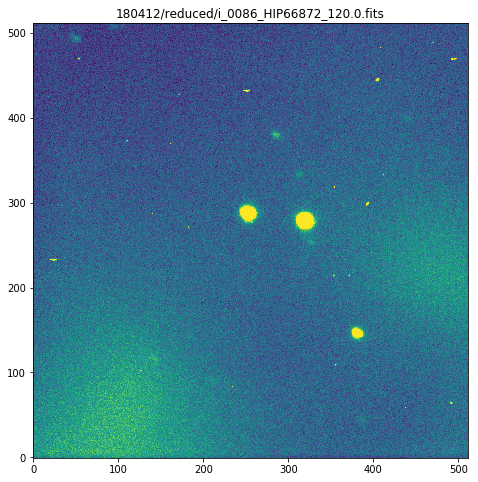

In [22]:
from matplotlib import pyplot as plt
from astropy.visualization import ZScaleInterval, ImageNormalize

def znorm(image):
    return ImageNormalize(image, interval=ZScaleInterval())


def zimshow(ax, image, **kwargs):
    return ax.imshow(image, norm=znorm(image), origin='lower', **kwargs)

f, ax = plt.subplots(figsize=(8,8))
zimshow(ax, objccd_bdf.data)
ax.set_title(objpath)
plt.show()

I am not sure what those bright pattern at the lower-left and middle-right (i'-band CCD only). Maybe some contaminating light..? The gradient is not negligible (~ 10%) and the pattern does appear in the raw images too, so it shouldn't be due to flat. Since the pattern does not appear on dark image, maybe it is not significant when the shutter is closed. The pattern slightly differ for our two targets, so maybe this is direction dependent, so I am just suspecting stray light from observing room or school buildings nearby the observatory. But I am not sure why it happens only in i'-band.

The ``ginga`` cut images are attached:

![](images/ginga_tripol.png)